In [3]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce

import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 822.6 kB/s eta 0:00:00


In [41]:
# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [42]:
# Function to limit categories to the top 5 most common
def limit_categories(df, column):
    top_5 = df[column].value_counts().index[:5]
    df[column] = df[column].apply(lambda x: x if x in top_5 else 'Other')
    return df

# Apply the function to both int_col and ext_col in train and test datasets
train_df = limit_categories(train_df, 'int_col')
train_df = limit_categories(train_df, 'ext_col')
test_df = limit_categories(test_df, 'int_col')
test_df = limit_categories(test_df, 'ext_col')


In [43]:
# Extract numerical values from the engine column
def extract_engine_power(engine_str):
    match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    if match:
        return float(match.group(1))
    return 0

train_df['engine_power'] = train_df['engine'].apply(extract_engine_power)
test_df['engine_power'] = test_df['engine'].apply(extract_engine_power)

# Drop the original engine column
train_df.drop(columns=['engine'], inplace=True)
test_df.drop(columns=['engine'], inplace=True)


In [44]:
# Add age of the car
train_df['age'] = 2024 - train_df['model_year']
test_df['age'] = 2024 - test_df['model_year']


In [45]:
# Remove outliers based on the price column
q1 = train_df['price'].quantile(0.25)
q3 = train_df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
train_df = train_df[(train_df['price'] >= lower_bound) & (train_df['price'] <= upper_bound)]

In [46]:
# Separate numeric and categorical columns, excluding 'price' from test set
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')  # Remove 'price' since it's not in test_df
categorical_cols = train_df.select_dtypes(exclude=[np.number]).columns.tolist()


In [47]:
# Separate the target column from the training set
y = train_df['price']
X_train_full = train_df.drop(columns=['price'])


In [48]:
# Encoding categorical variables
encoder = ce.OneHotEncoder(cols=categorical_cols, handle_unknown='ignore', use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_full)
X_test_encoded = encoder.transform(test_df)


In [49]:
# Standardize numerical features
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)


In [50]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)


In [51]:
# Build the Keras model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

In [52]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])


In [53]:

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
1280/1280 [==============================] - 14s 10ms/step - loss: 459430784.0000 - mse: 459430784.0000 - val_loss: 285051776.0000 - val_mse: 285051776.0000
Epoch 2/100
1280/1280 [==============================] - 16s 13ms/step - loss: 275679552.0000 - mse: 275679552.0000 - val_loss: 226115456.0000 - val_mse: 226115456.0000
Epoch 3/100
1280/1280 [==============================] - 15s 12ms/step - loss: 236005600.0000 - mse: 236005600.0000 - val_loss: 195182656.0000 - val_mse: 195182656.0000
Epoch 4/100
1280/1280 [==============================] - 14s 11ms/step - loss: 213734768.0000 - mse: 213734768.0000 - val_loss: 177392672.0000 - val_mse: 177392672.0000
Epoch 5/100
1280/1280 [==============================] - 15s 12ms/step - loss: 198999536.0000 - mse: 198999536.0000 - val_loss: 162866416.0000 - val_mse: 162866416.0000
Epoch 6/100
1280/1280 [==============================] - 19s 15ms/step - loss: 186472560.0000 - mse: 186472560.0000 - val_loss: 154029024.0000 - val_mse: 1

In [54]:
# Evaluate the model
val_predictions = model.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')


320/320 [==============================] - 1s 3ms/step
MSE: 131367369.92504933
R2 Score: 0.6414405870197979


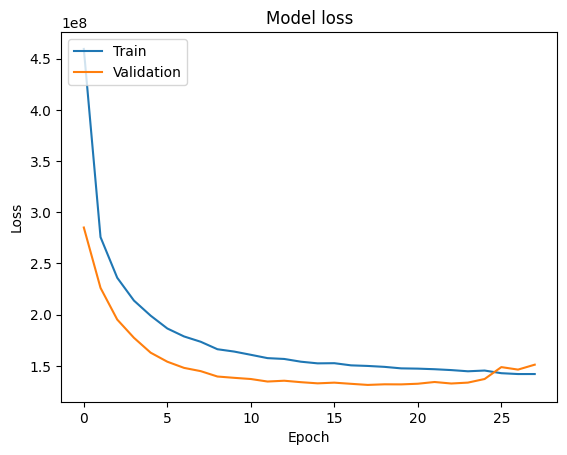

In [55]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




In [56]:
# Make predictions on the test set
test_predictions = model.predict(X_test_encoded)



1131/1131 [==============================] - 3s 3ms/step


In [57]:
# Flatten predictions array to 1D
test_predictions_flat = test_predictions.flatten()

# Replace any missing values in the predictions with the median of the predictions
median_price = np.median(test_predictions_flat[~np.isnan(test_predictions_flat)])  # Calculate median ignoring NaNs
test_predictions_flat = np.where(np.isnan(test_predictions_flat), median_price, test_predictions_flat)



In [58]:
# Create a DataFrame for the results
submission_df = pd.DataFrame({'id': test_df['id'], 'price': test_predictions_flat})

# Ensure there are no null values in the final CSV
submission_df['price'] = submission_df['price'].fillna(median_price)

# Save predictions to a CSV file in the required format
submission_df.to_csv('Test_Predictions_Keras_Adam_Final.csv', index=False)
